In [1]:
# MIT License

# Copyright (c) [2019] [Jayden Booth]

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# Import Libraries
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Dense, GaussianNoise,Lambda,Dropout, Concatenate
from keras.models import Model
from keras import regularizers
from keras.callbacks import EarlyStopping,Callback,ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam,SGD
from keras import backend as K
from keras.constraints import max_norm

from scipy import special
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Set random seeds
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(3)

In [3]:
# Set the defining parameters
# n = n_channel complex numbers (so 2n real numbers)
# k = log2(M), where M is the number of messages to encode
# EbNo is the energy per bit to noise power density

# Encoder Parameters
M = 16
k = np.log2(M)
n_channel = 1
#Transmit Power
P=1
#Power splitting ratio
rho = 1
#Power loss of splitter
eps = 1
#variance of antenna noise
w = 1
#rectifier efficiency
eta=1
noise_std = 1
print('number of symbols:',M)


number of symbols: 16


In [4]:
def set_up_train_nn(P,EsNodB):
    
    label = np.random.randint(M,size=N)
    # creating one hot encoded vectors
    data = []
    for i in label:
        temp = np.zeros(M)
        temp[i] = 1
        data.append(temp)
        # checking data shape
    data = np.array(data)
    print (data.shape)
    es = EarlyStopping(monitor='val_loss',patience=5, verbose=1)
    #callbacks = [EarlyStoppingByAccuracy(monitor='accuracy', value=0.98, verbose=1)]
    # Defined Autoencoder
    input_signal = Input(shape=(M,))
    encoded = Dense(M, activation='relu')(input_signal)
    encoded2 = Dense(2*n_channel, activation='linear')(encoded)

    # Normalize Power
    encoded3 = BatchNormalization(momentum=0,epsilon=1e-6,center=False,scale=False,axis=1)(encoded2)
    
    encoded4 = Lambda(lambda x: x*np.sqrt(P/2))(encoded3)

    #Add antenna noise
    encoded5 = Lambda(lambda x: x+K.random_normal_variable((4096,2), 0, 0.5)[0:tf.shape(x)[0],:])(encoded4)

    # Making CD data, and applying noise
    cd_data = Lambda(lambda x: np.sqrt(rho)*np.sqrt(eps)*x)(encoded5)

    # Reciever Layer
    decoded = Dense(M, activation='relu')(cd_data)
    decoded1 = Dense(M, activation='softmax')(decoded)
    autoencoder = Model(input_signal, decoded1)

    adam = Adam(lr=0.005)
    epochs=65
   
    
    autoencoder.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy'])
    

    # traning auto encoder
    history = autoencoder.fit(data, data,epochs=epochs,batch_size=2048,callbacks=[es],validation_split=0.3)
    
    
    # list all data in history
    print(history.history.keys())
    
    results = autoencoder.evaluate(data, data, batch_size=2048)
    print('test loss, test acc:', results)

    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # making encoder from full autoencoder
    encoder = Model(input_signal, encoded4)
    
    
    # for plotting learned consteallation diagram

    scatter_plot = []
    for i in range(0,M):
        temp = np.zeros(M)
        temp[i] = 1
        scatter_plot.append(encoder.predict(np.expand_dims(temp,axis=0)))
    scatter_plot = np.array(scatter_plot)
    print (scatter_plot.shape)
    
    # ploting constellation diagram
    
    scatter_plot = scatter_plot.reshape(M,2,1)

    plt.scatter(scatter_plot[:,0],scatter_plot[:,1])
    #plt.axis((-2,2,-2,2))
    plt.grid()
    #plt.title('Splitting Receiver: rho = '+str(rho)+' P = '+str(P))
    plt.xlabel('I Axis')
    plt.ylabel('Q Axis')
    plt.show()
    #p_av = np.sum(np.square(scatter_plot),axis=1)
    #print(sum(p_av)/16)
    
    return autoencoder

(10000, 16)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 7000 samples, validate on 3000 samples
Epoch 1/65
7000/7000 [==============================] - 1s 127us/step - loss: 2.8172 - acc: 0.0656 - val_loss: 2.7251 - val_acc: 0.0723
Epoch 2/65
7000/7000 [==============================] - 0s 2us/step - loss: 2.6895 - acc: 0.0856 - val_loss: 2.6231 - val_acc: 0.1237
Epoch 3/65
7000/7000 [==============================] - 0s 4us/step - loss: 2.5988 - acc: 0.1360 - val_loss: 2.5389 - val_acc: 0.1997
Epoch 4/65
7000/7000 [==============================] - 0s 2us/step - loss: 2.5270 - acc: 0.2143 - val_loss: 2.4803 - val_acc: 0.2360
Epoch 5/65
7000/7000 [==============================] - 0s 4us/step - loss: 2.4636 - acc: 0.2494 - val_loss: 2.4265 - val_acc: 0.2673
Epoch 6/65
7000/7000 [==============================] - 0s 2us/step - loss: 2.4129 - acc: 0.2777 - val_loss: 2.3692 - val_acc: 0.2830
Epoch 7/65
700

Epoch 00056: early stopping
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
10000/10000 [==============================] - 0s 2us/step
test loss, test acc: [1.705257803916931, 0.370199999666214]


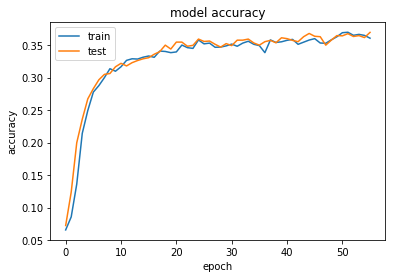

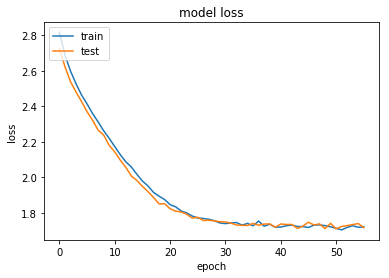

(16, 1, 2)


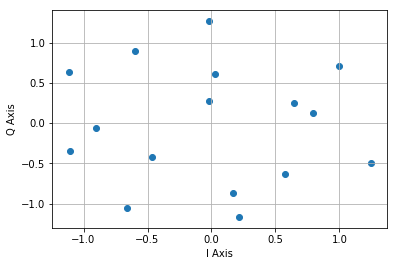

SNR: 0 SER: 0.683049 Theor_SER: 0.7409603642840197
(20000, 16)
Train on 14000 samples, validate on 6000 samples
Epoch 1/65
14000/14000 [==============================] - 1s 75us/step - loss: 2.6357 - acc: 0.0896 - val_loss: 2.4636 - val_acc: 0.1648
Epoch 2/65
14000/14000 [==============================] - 0s 3us/step - loss: 2.3878 - acc: 0.1877 - val_loss: 2.2786 - val_acc: 0.2357
Epoch 3/65
14000/14000 [==============================] - 0s 2us/step - loss: 2.2072 - acc: 0.2509 - val_loss: 2.1144 - val_acc: 0.2652
Epoch 4/65
14000/14000 [==============================] - 0s 2us/step - loss: 2.0387 - acc: 0.2862 - val_loss: 1.9550 - val_acc: 0.3190
Epoch 5/65
14000/14000 [==============================] - 0s 3us/step - loss: 1.8875 - acc: 0.3569 - val_loss: 1.8121 - val_acc: 0.3695
Epoch 6/65
14000/14000 [==============================] - 0s 2us/step - loss: 1.7488 - acc: 0.3886 - val_loss: 1.6783 - val_acc: 0.4107
Epoch 7/65
14000/14000 [==============================] - 0s 3us/step -

14000/14000 [==============================] - 0s 2us/step - loss: 0.7377 - acc: 0.7234 - val_loss: 0.7523 - val_acc: 0.7120
Epoch 61/65
14000/14000 [==============================] - 0s 3us/step - loss: 0.7300 - acc: 0.7254 - val_loss: 0.7433 - val_acc: 0.7200
Epoch 62/65
14000/14000 [==============================] - 0s 3us/step - loss: 0.7328 - acc: 0.7232 - val_loss: 0.7203 - val_acc: 0.7280
Epoch 63/65
14000/14000 [==============================] - 0s 2us/step - loss: 0.7422 - acc: 0.7184 - val_loss: 0.7339 - val_acc: 0.7193
Epoch 64/65
14000/14000 [==============================] - 0s 3us/step - loss: 0.7367 - acc: 0.7199 - val_loss: 0.7134 - val_acc: 0.7282
Epoch 65/65
14000/14000 [==============================] - 0s 3us/step - loss: 0.7325 - acc: 0.7230 - val_loss: 0.7261 - val_acc: 0.7227
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
20000/20000 [==============================] - 0s 1us/step
test loss, test acc: [0.7246039072036743, 0.7285999999046325]


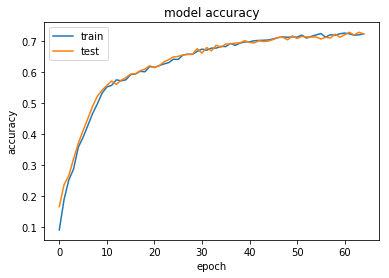

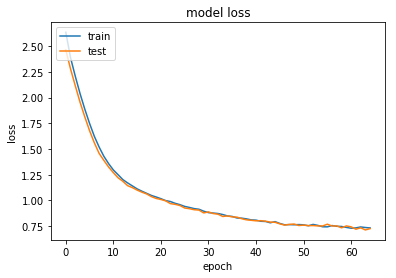

(16, 1, 2)


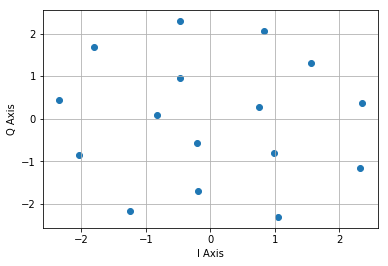

SNR: 6 SER: 0.281121 Theor_SER: 0.48040515806912654
(15000, 16)
Train on 10500 samples, validate on 4500 samples
Epoch 1/65
10500/10500 [==============================] - 1s 95us/step - loss: 3.2025 - acc: 0.0929 - val_loss: 2.6850 - val_acc: 0.1380
Epoch 2/65
10500/10500 [==============================] - 0s 3us/step - loss: 2.5237 - acc: 0.1704 - val_loss: 2.2210 - val_acc: 0.2084
Epoch 3/65
10500/10500 [==============================] - 0s 3us/step - loss: 2.1310 - acc: 0.2776 - val_loss: 1.9909 - val_acc: 0.3371
Epoch 4/65
10500/10500 [==============================] - 0s 3us/step - loss: 1.8986 - acc: 0.3810 - val_loss: 1.7972 - val_acc: 0.4216
Epoch 5/65
10500/10500 [==============================] - 0s 3us/step - loss: 1.7234 - acc: 0.4551 - val_loss: 1.6413 - val_acc: 0.4651
Epoch 6/65
10500/10500 [==============================] - 0s 3us/step - loss: 1.5766 - acc: 0.4848 - val_loss: 1.4953 - val_acc: 0.5053
Epoch 7/65
10500/10500 [==============================] - 0s 3us/step 

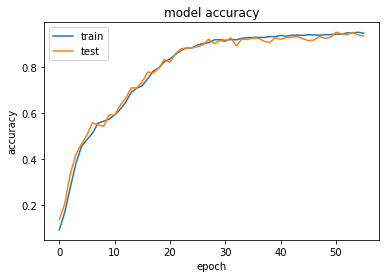

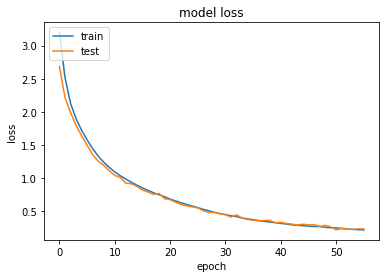

(16, 1, 2)


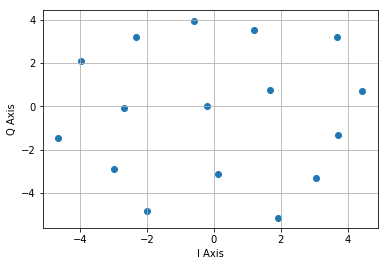

SNR: 12 SER: 0.040838 Theor_SER: 0.10935328833170666
(16000, 16)
Train on 11200 samples, validate on 4800 samples
Epoch 1/65
11200/11200 [==============================] - 1s 92us/step - loss: 3.2276 - acc: 0.0031 - val_loss: 2.6917 - val_acc: 0.0590
Epoch 2/65
11200/11200 [==============================] - 0s 4us/step - loss: 2.4566 - acc: 0.1300 - val_loss: 2.1435 - val_acc: 0.2792
Epoch 3/65
11200/11200 [==============================] - 0s 4us/step - loss: 2.0226 - acc: 0.3675 - val_loss: 1.8520 - val_acc: 0.4423
Epoch 4/65
11200/11200 [==============================] - 0s 4us/step - loss: 1.7750 - acc: 0.4683 - val_loss: 1.6504 - val_acc: 0.4929
Epoch 5/65
11200/11200 [==============================] - 0s 7us/step - loss: 1.5981 - acc: 0.4919 - val_loss: 1.4907 - val_acc: 0.4971
Epoch 6/65
11200/11200 [==============================] - 0s 4us/step - loss: 1.4507 - acc: 0.5087 - val_loss: 1.3684 - val_acc: 0.5346
Epoch 7/65
11200/11200 [==============================] - 0s 4us/step

11200/11200 [==============================] - 0s 3us/step - loss: 0.1292 - acc: 0.9785 - val_loss: 0.1403 - val_acc: 0.9744
Epoch 61/65
11200/11200 [==============================] - 0s 4us/step - loss: 0.1251 - acc: 0.9781 - val_loss: 0.1238 - val_acc: 0.9777
Epoch 62/65
11200/11200 [==============================] - 0s 3us/step - loss: 0.1234 - acc: 0.9783 - val_loss: 0.1235 - val_acc: 0.9798
Epoch 63/65
11200/11200 [==============================] - 0s 3us/step - loss: 0.1197 - acc: 0.9800 - val_loss: 0.1221 - val_acc: 0.9779
Epoch 64/65
11200/11200 [==============================] - 0s 3us/step - loss: 0.1168 - acc: 0.9796 - val_loss: 0.1170 - val_acc: 0.9812
Epoch 65/65
11200/11200 [==============================] - 0s 3us/step - loss: 0.1109 - acc: 0.9816 - val_loss: 0.1201 - val_acc: 0.9769
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
16000/16000 [==============================] - 0s 1us/step
test loss, test acc: [0.11740052664279937, 0.977812497138977]


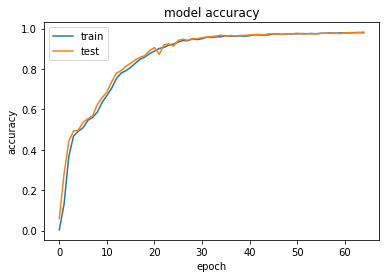

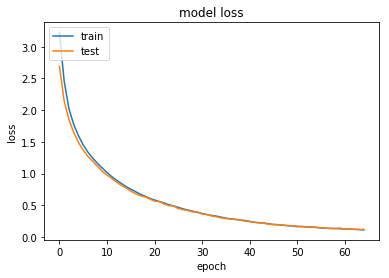

(16, 1, 2)


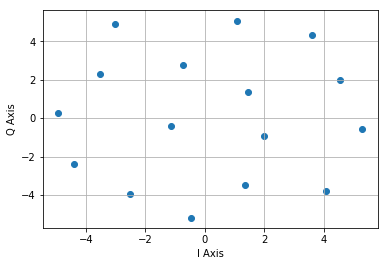

SNR: 13 SER: 0.021337 Theor_SER: 0.06745752423506102
(26000, 16)
Train on 18200 samples, validate on 7800 samples
Epoch 1/65
18200/18200 [==============================] - 1s 63us/step - loss: 2.9748 - acc: 0.0750 - val_loss: 2.3036 - val_acc: 0.2297
Epoch 2/65
18200/18200 [==============================] - 0s 3us/step - loss: 2.1220 - acc: 0.2636 - val_loss: 1.9127 - val_acc: 0.3850
Epoch 3/65
18200/18200 [==============================] - 0s 3us/step - loss: 1.8076 - acc: 0.3708 - val_loss: 1.7021 - val_acc: 0.3944
Epoch 4/65
18200/18200 [==============================] - 0s 3us/step - loss: 1.5947 - acc: 0.4375 - val_loss: 1.4979 - val_acc: 0.4419
Epoch 5/65
18200/18200 [==============================] - 0s 3us/step - loss: 1.4204 - acc: 0.4553 - val_loss: 1.3184 - val_acc: 0.4668
Epoch 6/65
18200/18200 [==============================] - 0s 3us/step - loss: 1.2521 - acc: 0.5492 - val_loss: 1.1542 - val_acc: 0.6162
Epoch 7/65
18200/18200 [==============================] - 0s 3us/step

18200/18200 [==============================] - 0s 3us/step - loss: 0.0298 - acc: 0.9985 - val_loss: 0.0282 - val_acc: 0.9982
Epoch 61/65
18200/18200 [==============================] - 0s 3us/step - loss: 0.0297 - acc: 0.9981 - val_loss: 0.0292 - val_acc: 0.9990
Epoch 62/65
18200/18200 [==============================] - 0s 3us/step - loss: 0.0282 - acc: 0.9982 - val_loss: 0.0272 - val_acc: 0.9983
Epoch 63/65
18200/18200 [==============================] - 0s 3us/step - loss: 0.0276 - acc: 0.9986 - val_loss: 0.0279 - val_acc: 0.9982
Epoch 64/65
18200/18200 [==============================] - 0s 3us/step - loss: 0.0264 - acc: 0.9983 - val_loss: 0.0259 - val_acc: 0.9982
Epoch 65/65
18200/18200 [==============================] - 0s 3us/step - loss: 0.0257 - acc: 0.9987 - val_loss: 0.0257 - val_acc: 0.9981
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
26000/26000 [==============================] - 0s 1us/step
test loss, test acc: [0.025434297585716616, 0.998423076923077]


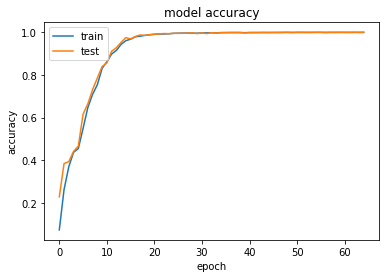

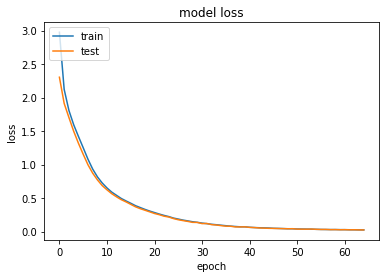

(16, 1, 2)


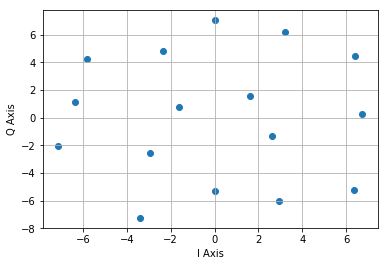

SNR: 16 SER: 0.00197 Theor_SER: 0.007152038493876245


In [5]:
# Calculating SER from -4dB to 14dB SNR
EsNodB_range = [0,6,12,13,16]
N_array = [10000,20000,15000,16000,26000]
ser = [None]*len(EsNodB_range)
theor_ser = [None]*len(EsNodB_range)

for n in range(0,len(EsNodB_range)):
    
    
    EsNo=10.0**(EsNodB_range[n]/10.0)
    P = EsNo*(noise_std**2)
    no_errors = 0
    
    N = N_array[n]
    autoencoder = set_up_train_nn(P,EsNodB_range[n])
    
    N=1000000    
    test_data = []
    test_label = np.random.randint(M,size=N)
    for i in test_label:
        temp = np.zeros(M)
        temp[i] = 1
        test_data.append(temp)

    test_data = np.array(test_data)
    
    pred_final_signal = autoencoder.predict(test_data)
    pred_output = np.argmax(pred_final_signal,axis=1)
    
    no_errors = (pred_output != test_label)
    no_errors =  no_errors.astype(int).sum()
    ser[n] = (no_errors/N).astype('float64') 
    
    P_sqrtM = 0.75*special.erfc(np.sqrt(EsNo/10))
    theor_ser[n] = 1-(1-P_sqrtM)**2
    
    print ('SNR:',EsNodB_range[n],'SER:',ser[n],'Theor_SER:',theor_ser[n])

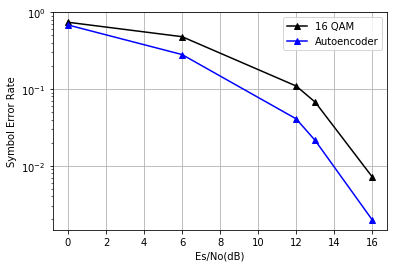

In [6]:
# ploting BER curve
import matplotlib.pyplot as plt
from scipy import interpolate
plt.plot(EsNodB_range, theor_ser, 'k^-',label='16 QAM')
plt.plot(EsNodB_range, ser, 'b^-',label='Autoencoder')
plt.yscale('log')
plt.xlabel('Es/No(dB)')
plt.ylabel('Symbol Error Rate')
#plt.ylim((10e-3,10e0))
plt.grid()
plt.legend(loc='best',ncol = 1)
plt.show()

In [7]:
    N=1000000    
    test_data = []
    test_label = np.random.randint(M,size=N)
    for i in test_label:
        temp = np.zeros(M)
        temp[i] = 1
        test_data.append(temp)

    test_data = np.array(test_data)
    
    pred_final_signal = autoencoder.predict(test_data)
    pred_output = np.argmax(pred_final_signal,axis=1)
    
    no_errors = (pred_output != test_label)
    no_errors =  no_errors.astype(int).sum()
    ser = (no_errors/N).astype('float64') 
    ser

0.002075

In [8]:
theor_ser = theor_ser[:-1]
ser = ser[:-1]
EsNodB_range = EsNodB_range[:-1]
# ploting BER curve
import matplotlib.pyplot as plt
from scipy import interpolate
plt.plot(EsNodB_range, theor_ser, 'k^-',label='16 QAM')
plt.plot(EsNodB_range, ser, 'b^-',label='Conventional Coherent')
plt.yscale('log')
plt.xlabel('Es/No(dB)')
plt.ylabel('Symbol Error Rate')
plt.grid()
plt.legend(loc='best',ncol = 1)
plt.show()

IndexError: invalid index to scalar variable.